In [1]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt

In [2]:
AUDUSD = pd.read_csv('../Datasets/AUDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
EURUSD = pd.read_csv('../Datasets/EURUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
GBPUSD = pd.read_csv('../Datasets/GBPUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
NZDUSD = pd.read_csv('../Datasets/NZDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCAD = pd.read_csv('../Datasets/USDCAD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCHF = pd.read_csv('../Datasets/USDCHF_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDJPY = pd.read_csv('../Datasets/USDJPY_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')

In [3]:
df_pair = {}
df_pair['AUDUSD'] = AUDUSD
df_pair['EURUSD'] = EURUSD
df_pair['GBPUSD'] = GBPUSD
df_pair['NZDUSD'] = NZDUSD
df_pair['USDCAD'] = USDCAD
df_pair['USDCHF'] = USDCHF
df_pair['USDJPY'] = USDJPY
df_train = {}
df_test = {}
names = list(df_pair.keys())
for i in range(len(df_pair)):
    df = df_pair[names[i]]
    df = df.drop(df[df.Volume == 0].index)
    df = df.rename(columns={'Gmt time': 'Date'})
    #AUDUSD['Date'] =  pd.to_times(AUDUSD['Date'])
    #AUDUSD.set_index('Date', inplace=True)

    df['Day'] = df['Date'].astype(str).str[0:2]
    df['Month'] = df['Date'].astype(str).str[3:5]
    df['Year'] = df['Date'].astype(str).str[6:10]
    df['Hour'] = df['Date'].astype(str).str[11:13]
    df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year', 'Hour']])
    df.set_index('Date', inplace=True)
    #df = df.query("20210701 < index < 20211226")
    
    df['MA20'] = df.Close.rolling(window=20).mean()
    df['MA50'] = df.Close.rolling(window=50).mean()
    
    df.dropna(inplace = True)
    
    df = df[["Close","MA20","MA50"]]
    

    df_pair[names[i]] = df
    # Train
    df_train[names[i]] = df_pair[names[i]].query("20190630 < index < 20210701")
    # Test
    df_test[names[i]] = df_pair[names[i]].query("20210701 < index < 20211226")

## 1. Example

In [4]:
df1 = df_train['AUDUSD']
df1 = df1.head(900)

In [5]:
buys1 = []
sells1 = []
open_pos1 = False

for i in range(len(df1)):
    
    # Buying signal: if the MA of 20 days is above the MA of 50 days, but isn't the day before
    # Selling signal: if the MA of 50 days is above the MA of 20 days, but isn't the day before
    if df1.MA20.iloc[i] > df1.MA50.iloc[i] and df1.MA20.iloc[i-1] < df1.MA50.iloc[i-1]:
        if open_pos1 == False:
            buys1.append(i)
            open_pos1 = True
    elif df1.MA20.iloc[i] < df1.MA50.iloc[i] and df1.MA20.iloc[i-1] > df1.MA50.iloc[i-1]:
        if open_pos1:
            sells1.append(i)
            open_pos1 = False

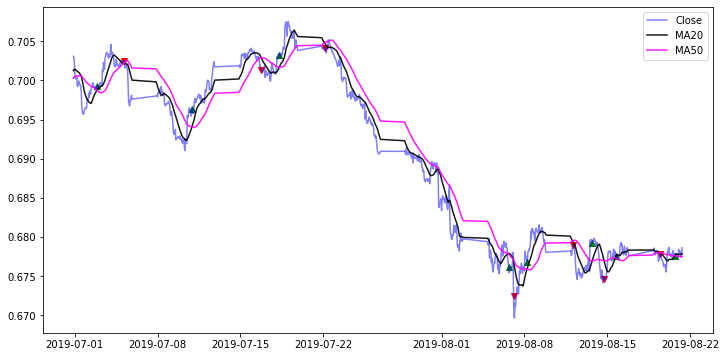

In [6]:
plt.figure(figsize = (12,6))
plt.plot(df1['Close'], label = 'Asset price', c = 'blue', alpha = 0.5)
plt.plot(df1['MA20'], label = 'MA20', c = 'k', alpha = 0.9)
plt.plot(df1['MA50'], label = 'MA50', c = 'magenta', alpha = 0.9)
plt.scatter(df1.iloc[buys1].index, df1.iloc[buys1].Close, marker = '^', color = 'g')
plt.scatter(df1.iloc[sells1].index, df1.iloc[sells1].Close, marker = 'v', color = 'r')
plt.legend(['Close','MA20','MA50'])
plt.show()

In [7]:
def return_calculator(df):
    df1 = df
    buys1 = []
    sells1 = []
    open_pos1 = False

    for i in range(len(df1)):
        # Buying signal: if the MA of 20 days is above the MA of 50 days, but isn't the day before
        # Selling signal: if the MA of 50 days is above the MA of 20 days, but isn't the day before
        if df1.MA20.iloc[i] > df1.MA50.iloc[i] and df1.MA20.iloc[i-1] < df1.MA50.iloc[i-1]:
            if open_pos1 == False:
                buys1.append(i)
                open_pos1 = True
        elif df1.MA20.iloc[i] < df1.MA50.iloc[i] and df1.MA20.iloc[i-1] > df1.MA50.iloc[i-1]:
            if open_pos1:
                sells1.append(i)
                open_pos1 = False
                
    df_p = df1
    df_p = df_p.reset_index()
    merged = pd.concat([df_p.iloc[buys1].Close, df_p.iloc[sells1].Close], axis = 1)
    merged.columns = ['Buys','Sells']
    
    trade_fee = 0.0003
    
    totalprofit_long = (merged.shift(-1).Sells - merged.Buys - trade_fee)*10000
    totalprofit_sort = (merged.shift(-1).Buys - merged.Sells - trade_fee)*10000

    totalprofit_sum = totalprofit_long.sum() + totalprofit_sort.sum()

    relprofit_long = (merged.shift(-1).Sells - merged.Buys)/merged.Buys
    relprofit_sort = (merged.shift(-1).Buys - merged.Sells)/merged.Sells
    relprofit = (relprofit_long.sum() + relprofit_sort.sum())*100
    
    profit = [totalprofit_sum, relprofit]

    #totalprofit.dropna(inplace=True)

    #relprofit = (merged.shift(-1).Sells - merged.Buys)/merged.Buys
    return(profit)

In [8]:
for i in range(len(df_pair)):
    profit_train = return_calculator(df_train[names[i]])
    profit_test = return_calculator(df_test[names[i]])
    
    print ("#"*40,"\n","- Resultados Train para la divisa " + str(names[i])) #get name of columns/features
 #   print('El profit es de '+ str(profit_train[0]))
    print('El profit relativo es de '+ str(profit_train[1]) + '%')
    
    print ("- Resultados Test para la divisa " + str(names[i])) #get name of columns/features
#    print('El profit es de '+ str(profit_test[0]))
    print('El profit relativo es de '+ str(profit_test[1]) + '%')

######################################## 
 - Resultados Train para la divisa AUDUSD
El profit relativo es de 8.679596593892866%
- Resultados Test para la divisa AUDUSD
El profit relativo es de -5.182929646774573%
######################################## 
 - Resultados Train para la divisa EURUSD
El profit relativo es de 5.382868446796768%
- Resultados Test para la divisa EURUSD
El profit relativo es de -4.664261207255322%
######################################## 
 - Resultados Train para la divisa GBPUSD
El profit relativo es de 10.444372796802247%
- Resultados Test para la divisa GBPUSD
El profit relativo es de -4.23499736765351%
######################################## 
 - Resultados Train para la divisa NZDUSD
El profit relativo es de 6.146575836699968%
- Resultados Test para la divisa NZDUSD
El profit relativo es de -2.5743957329329423%
######################################## 
 - Resultados Train para la divisa USDCAD
El profit relativo es de -5.55395047241324%
- Resultados Test p